In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [2]:
file_path = 'dataset.csv'
data = pd.read_csv(file_path)

In [10]:
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    10320 non-null  int64         
 1   timestamp     10320 non-null  datetime64[ns]
 2   value         10320 non-null  int64         
 3   hour          10320 non-null  int32         
 4   day_of_week   10320 non-null  int32         
 5   value_scaled  10320 non-null  float64       
 6   cluster       10320 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(3), int64(2)
memory usage: 443.6 KB
None
         Unnamed: 0            timestamp         value          hour  \
count  10320.000000                10320  10320.000000  10320.000000   
mean    5159.500000  2014-10-16 11:45:00  15137.569380     11.500000   
min        0.000000  2014-07-01 00:00:00      8.000000      0.000000   
25%     2579.750000  2014-08-23 17:52:30  10262.000000      5.750000

In [3]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['hour'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.dayofweek

In [34]:
holidays = [
    "2014-01-01", "2015-01-01",  # New Year's Day
    "2014-07-04", "2015-07-04",  # Independence Day
    "2014-11-27", "2015-11-26",  # Thanksgiving
    "2014-12-25", "2015-12-25",  # Christmas
    "2014-12-31", "2015-12-31",  # New Year's Eve
    "2014-11-02", "2015-11-01",  # NYC Marathon (first Sunday in November)
]

In [42]:
holidays = [datetime.strptime(date, "%Y-%m-%d") for date in holidays]
data['is_holiday'] = data['timestamp'].dt.date.isin([holiday.date() for holiday in holidays]).astype(int)


In [21]:
data = data.drop(columns=['Unnamed: 0'])

In [11]:
missing_timestamps = data['timestamp'].isna().sum()

In [12]:
data = data.dropna(subset=['timestamp'])

In [43]:
scaler = StandardScaler()
data['value_scaled'] = scaler.fit_transform(data[['value']])

In [44]:
features = data[['hour', 'day_of_week', 'value_scaled', 'is_holiday']]

In [19]:
initial_row_count = len(data)
data = data.drop_duplicates()
final_row_count = len(data)

In [45]:
print(f"Missing timestamps: {missing_timestamps}")
print(f"Duplicate rows removed: {initial_row_count - final_row_count}")
print(data.info())
print(data.describe())

Missing timestamps: 0
Duplicate rows removed: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     10320 non-null  datetime64[ns]
 1   value         10320 non-null  int64         
 2   hour          10320 non-null  int32         
 3   day_of_week   10320 non-null  int32         
 4   value_scaled  10320 non-null  float64       
 5   cluster       10320 non-null  int32         
 6   is_holiday    10320 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(3), int64(2)
memory usage: 443.6 KB
None
                 timestamp         value          hour   day_of_week  \
count                10320  10320.000000  10320.000000  10320.000000   
mean   2014-10-16 11:45:00  15137.569380     11.500000      3.000000   
min    2014-07-01 00:00:00      8.000000      0.000000      0.000000   
25%    2014-08-23 17

In [46]:
silhouette_scores = []
k_values = range(2, 11) 

In [47]:
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(features)
    silhouette_avg = silhouette_score(features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

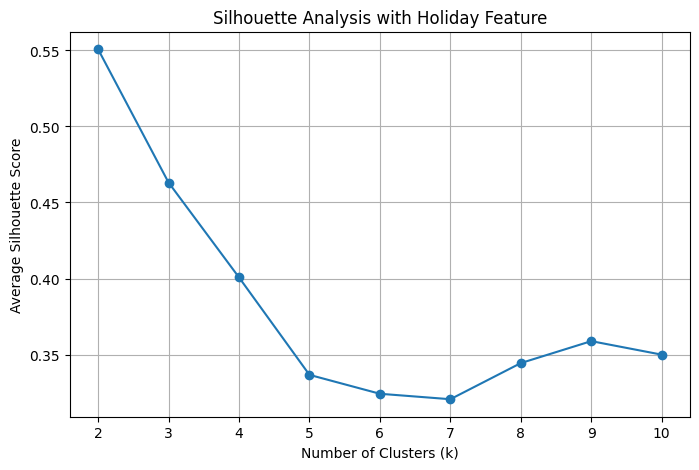

In [51]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Analysis with Holiday Feature')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.grid(True)
plt.show()

In [52]:
optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal k with holiday feature: {optimal_k}")

Optimal k with holiday feature: 2


In [53]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['cluster'] = kmeans.fit_predict(features)

In [54]:
print("Cluster Centers with holiday feature:\n", kmeans.cluster_centers_)

Cluster Centers with holiday feature:
 [[17.5         3.          0.60541148  0.02790698]
 [ 5.5         3.         -0.60541148  0.02790698]]


In [56]:
for cluster in range(optimal_k):
    cluster_data = data[data['cluster'] == cluster]
    print(f"Cluster {cluster}:")
    print(cluster_data[['hour', 'day_of_week', 'value', 'is_holiday']].describe())

Cluster 0:
              hour  day_of_week         value   is_holiday
count  5160.000000  5160.000000   5160.000000  5160.000000
mean     17.500000     3.000000  19338.616279     0.027907
std       3.452387     1.988531   4014.694251     0.164722
min      12.000000     0.000000    189.000000     0.000000
25%      14.750000     1.000000  16625.500000     0.000000
50%      17.500000     3.000000  18790.000000     0.000000
75%      20.250000     5.000000  22502.000000     0.000000
max      23.000000     6.000000  30373.000000     1.000000
Cluster 1:
              hour  day_of_week         value   is_holiday
count  5160.000000  5160.000000   5160.000000  5160.000000
mean      5.500000     3.000000  10936.522481     0.027907
std       3.452387     1.988531   6700.771348     0.164722
min       0.000000     0.000000      8.000000     0.000000
25%       2.750000     1.000000   4413.000000     0.000000
50%       5.500000     3.000000  10604.500000     0.000000
75%       8.250000     5.000000  1